In [5]:
import ufl
import numpy as np

from mpi4py import MPI
from petsc4py import PETSc

import dolfinx.fem.petsc  # needed to carry out the init :(
import dolfinx as dfx
from dolfinx.fem import Constant
from ufl import grad, inner, div

SEC_IN_DAY = float(24 * 60 * 60)

# Tunnel ellipse, part of the input, efficiently mesh information
TUNNEL_X_HALF_AXIS = 4.375 / 2
TUNNEL_Y_HALF_AXIS = 3.5 / 2

# Parameters of the inner ellipses, guesstimated to match Standa's drawing, see picture in NLAA paper
INNER_X_HALF_AXIS = 1
INNER_Y_HALF_AXIS = 3.5 / 2 + 0.75 / 2

OUTER_X_HALF_AXIS = 4.375 / 2 + 0.75
OUTER_Y_HALF_AXIS = 3.5 / 2 + 0.75

# just for output, to be deleted in final version
XDMF_OUT = False
PICTURE_DATA = True


def epsilon(u):
    return ufl.sym(ufl.nabla_grad(u))


def boundary_outer(x):
    return np.logical_or(np.logical_or(np.isclose(x[0], -50), np.isclose(x[0], 50)),
                         np.logical_or(np.isclose(x[1], -50), np.isclose(x[1], 50)))


def boundary_outer_lr(x):
    return np.logical_or(np.isclose(x[0], -50), np.isclose(x[0], 50))


def boundary_outer_bt(x):
    return np.logical_or(np.isclose(x[1], -50), np.isclose(x[1], 50))


def boundary_inner(x):
    return np.isclose(x[0]**2 / TUNNEL_X_HALF_AXIS**2 + x[1]**2 / TUNNEL_Y_HALF_AXIS**2, 1.0)


# "Marker" true/false function for the subdomains
def innermost_ellipse(x):
    return x[0]**2 / INNER_X_HALF_AXIS**2 + x[1]**2 / INNER_Y_HALF_AXIS**2 <= 1


def outer_ellipse(x):
    return np.logical_and(np.logical_not(innermost_ellipse(x)),
                          (x[0]**2 / OUTER_X_HALF_AXIS**2 + x[1]**2 / OUTER_Y_HALF_AXIS**2 <= 1))


def undisturbed_massif(x):
    return np.logical_and(np.logical_not(innermost_ellipse(x)), np.logical_not(outer_ellipse(x)))


def tsx(mesh, lmbda, mu, alpha, cpp, k_massif, k_outer_ellipse, k_inner_ellipse, tau, sigma_xx=-45e6, sigma_yy=-11e6):
    lmbda = Constant(mesh, lmbda)
    mu = Constant(mesh, mu)
    alpha = Constant(mesh, alpha)
    cpp = Constant(mesh, cpp)
    tau_f = tau  # useful to have around as float
    tau = Constant(mesh, tau)  # useful for matrix assembly

    pressure_init = 3e6  # water pressure in the massive, initial and outer condition for pressure

    # Spaces and functions
    P2 = ufl.VectorElement("Lagrange", mesh.ufl_cell(), 2)
    P1 = ufl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    V_element = ufl.MixedElement(P2, P1)
    V = dfx.fem.FunctionSpace(mesh, V_element)
    u, p = ufl.TrialFunctions(V)
    w, q = ufl.TestFunctions(V)
    x_h = dfx.fem.Function(V)
    Q = dfx.fem.FunctionSpace(mesh, P1)  # (only) for permeability function

    # subdomains implemented as a modification of a measure, can be precomputed and used as input
    # https://fenicsproject.discourse.group/t/define-bilinear-form-with-subdomains/11943
    domain_functions = {
        1: innermost_ellipse,
        2: outer_ellipse,
        3: undisturbed_massif
    }
    domain_indices, domain_markers = [], []
    for tag in domain_functions:
        entities = dfx.mesh.locate_entities(mesh, 2, domain_functions[tag])
        domain_indices.append(entities)
        domain_markers.append(np.full_like(entities, tag))

    domain_indices = np.hstack(domain_indices).astype(np.int32)
    domain_markers = np.hstack(domain_markers).astype(np.int32)
    sorted_domain = np.argsort(domain_indices)
    subdomain_tag = dfx.mesh.meshtags(mesh, 2, domain_indices[sorted_domain], domain_markers[sorted_domain])
    dx = ufl.Measure('dx', domain=mesh, subdomain_data=subdomain_tag)

    # infrastructure for solution evaluation, can be precomputed and used as input
    bb_tree = dfx.geometry.bb_tree(mesh, mesh.topology.dim)
    evaluation_points = np.zeros((3, 4))  # must be 3D, for some reason
    evaluation_points[0, :] = [0, 0, 0 + 4.375 / 2 + 4.0, 0 + 4.375 / 2 + 1.5]
    evaluation_points[1, :] = [0 + 3.5 / 2 + 1.5, 0 + 3.5 / 2 + 4.0, 0, 0]
    cells_t = []
    points_on_proc_t = []
    cell_candidates_t = dfx.geometry.compute_collisions_points(bb_tree, evaluation_points.T)
    colliding_cells_t = dfx.geometry.compute_colliding_cells(mesh, cell_candidates_t, evaluation_points.T)
    for i, point in enumerate(evaluation_points.T):
        if len(colliding_cells_t.links(i)) > 0:
            points_on_proc_t.append(point)
            cells_t.append(colliding_cells_t.links(i)[0])

    ready_eval_points = np.array(points_on_proc_t, dtype=np.float64)

    # bc -> zero normal displacements, 3e6 outer pressure and 3e6 to zero pressure in tunnel
    # all of this can be also precomputed and used as input
    # Dirichlet
    # TODO: use dict and cycle
    lr_edges = dfx.mesh.locate_entities_boundary(mesh, 1, boundary_outer_lr)
    dofs_displacement_lr = dfx.fem.locate_dofs_topological(V.sub(0).sub(0), 1, lr_edges)
    bc_elastic_lr = dfx.fem.dirichletbc(Constant(mesh, 0.0), dofs_displacement_lr, V.sub(0).sub(0))

    bt_edges = dfx.mesh.locate_entities_boundary(mesh, 1, boundary_outer_bt)
    dofs_displacement_bt = dfx.fem.locate_dofs_topological(V.sub(0).sub(1), 1, bt_edges)
    bc_elastic_bt = dfx.fem.dirichletbc(Constant(mesh, 0.0), dofs_displacement_bt, V.sub(0).sub(1))

    outer_edges = dfx.mesh.locate_entities_boundary(mesh, 1, boundary_outer)
    dofs_pressure_outer = dfx.fem.locate_dofs_topological(V.sub(1), 1, outer_edges)
    bc_pressure_outer = dfx.fem.dirichletbc(Constant(mesh, pressure_init), dofs_pressure_outer, V.sub(1))

    pbc_expression = Constant(mesh, pressure_init * max(0.0, 1 - tau_f / (17 * SEC_IN_DAY)))
    inner_edges = dfx.mesh.locate_entities_boundary(mesh, 1, boundary_inner)
    dofs_pressure_inner = dfx.fem.locate_dofs_topological(V.sub(1), 1, inner_edges)
    bc_pressure_inner = dfx.fem.dirichletbc(pbc_expression, dofs_pressure_inner, V.sub(1))

    bcs = [bc_elastic_lr, bc_elastic_bt, bc_pressure_inner, bc_pressure_outer]

    # Neumann - not needed at all, potentionally usefull for 3 field formulation, can be deleted for production
    facets = dfx.mesh.locate_entities_boundary(mesh, 1, boundary_inner)
    facet_marker = np.full_like(facets, 1)
    facet_tag = dfx.mesh.meshtags(mesh, 1, facets, facet_marker)
    ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag)
    n = ufl.FacetNormal(mesh)

    # form construction
    sigma_init = Constant(mesh, np.array([[sigma_xx, 0], [0, sigma_yy]]))
    sigma_expression = Constant(mesh, min(1.0, tau_f / (17 * SEC_IN_DAY)))

    domain_values = {
        1: k_inner_ellipse,
        2: k_outer_ellipse,
        3: k_massif
    }
    ff_term = cpp / tau * p * q * dx  # flux-flux term
    for tag in domain_values:
        ff_term += domain_values[tag] * inner(grad(p), grad(q)) * dx(tag)

    a = dfx.fem.form(2 * mu * inner(epsilon(u), epsilon(w)) * dx + lmbda * div(u) * div(w) * dx - alpha * p * div(w) * dx +
                     alpha / tau * q * div(u) * dx + ff_term)

    # rhs construction
    f = Constant(mesh, (0.0, 0.0))  # elastic volume force
    g = Constant(mesh, 0.0)  # pressure volume force

    L = dfx.fem.form(inner(f, w) * dx + g * q * dx +
                     cpp / tau * pressure_init * q * dx -
                     sigma_expression * inner(sigma_init, epsilon(w)) * dx)

    # assembly and set bcs
    A = dfx.fem.petsc.assemble_matrix(a, bcs=bcs)
    A.assemble()
    b = dfx.fem.petsc.assemble_vector(L)
    dfx.fem.petsc.apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    dfx.fem.set_bc(b, bcs)

    # PETSc4py section with solver setup
    solver = PETSc.KSP().create(mesh.comm)
    solver.setOperators(A, A)
    solver.setType('preonly')
    solver.getPC().setType('lu')
    opts = PETSc.Options()
    opts['pc_factor_mat_solver_type'] = 'mumps'
    solver.setFromOptions()

    # solve for first timestep
    solver.solve(b, x_h.vector)
    x_h.x.scatter_forward()
    u_h, p_h = x_h.split()

    if PICTURE_DATA:
        pressure_values = []
        pressure_values.append(p_h.eval(ready_eval_points, cells_t))

    if XDMF_OUT:
        pressure_file = dfx.io.XDMFFile(mesh.comm, 'Michal_tsx_pressure.xdmf', 'w')
        pressure_file.write_mesh(mesh)
        pressure_file.write_function(p_h, tau_f)

    # Time loop
    # TODO: Tie all of the code into the big time loop
    current_time = tau_f
    t_steps_num = 400*10
    for _ in range(2, t_steps_num):
        current_time += tau_f
        sigma_expression.value = min(1.0, current_time / (17 * SEC_IN_DAY))
        pbc_expression.value = pressure_init * max(0.0, 1 - current_time / (17 * SEC_IN_DAY))
        L = dfx.fem.form(inner(f, w) * dx + g * q * dx +
                         alpha / tau * div(u_h) * q * dx + cpp / tau * p_h * q * dx -
                         sigma_expression * inner(sigma_init, epsilon(w)) * dx)

        b = dfx.fem.petsc.assemble_vector(L)
        dfx.fem.petsc.apply_lifting(b, [a], [bcs])  # ???
        b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        dfx.fem.set_bc(b, bcs)
        solver.solve(b, x_h.vector)
        x_h.x.scatter_forward()
        u_h, p_h = x_h.split()

        if XDMF_OUT:
            pressure_file.write_function(p_h, current_time / SEC_IN_DAY)
        if PICTURE_DATA:
            pressure_values.append(p_h.eval(ready_eval_points, cells_t))

    return pressure_values

In [6]:
import matplotlib.pyplot as plt
young_e = 6e10
poisson_nu = 0.2
mu = young_e/(2 * (1 + poisson_nu))
lmbda = young_e * poisson_nu/((1 + poisson_nu)*(1 - 2*poisson_nu))
alpha = 0.2
cpp = 7.712e-12

# meshfile_name = 'tsx_inner_layer.xdmf'
meshfile_name = 'michal_mesh.xdmf'
with dfx.io.XDMFFile(MPI.COMM_WORLD, meshfile_name, 'r') as mesh_file:
    mesh = mesh_file.read_mesh(name='Grid')


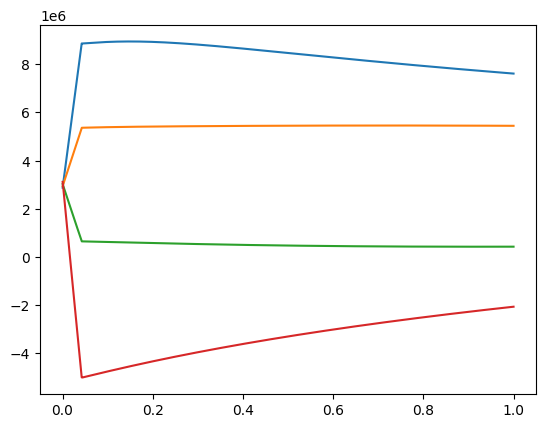

In [8]:

data = tsx(mesh, lmbda, mu, 1.0, cpp, 6e-19, 6e-16, 6e-13, SEC_IN_DAY/10)
data_fp = np.zeros((4, len(data)))
for i, item in enumerate(data):
    data_fp[:, i] = [value[0] for value in data[i]]

for timeline in data_fp:
    plt.plot(np.linspace(1 / len(timeline), 1, len(timeline), endpoint=True), timeline)
plt.show()